In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.4 MB/s eta 0:00:00


In [2]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=e93e2904ee7b95fb959cbccedf7b95feea6be38c12a9e08954f92b79cc998af7
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.9-py3-none-any.whl size=55620 sha256=473b99ce7fd5fa4e1208944696a3ac1cbc4b40eafd585a4e3006ffdf55e440df
  Stored in directory: /root/.cache/pip/wheels/eb/f2/e3/b8e73d1488d8284d88c9283411561b65bd4f0200abf131a946
Successfully built umap-learn pynndescent


In [3]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.5 MB/s eta 0:00:00


In [4]:
!pip install pytorch_metric_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.4 MB/s eta 0:00:00


In [5]:
import umap.umap_ as umap
import random

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import pandas as pd
from torch.optim import lr_scheduler
import time
import torchmetrics
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from pytorch_metric_learning import losses
from PIL import Image
from pytorch_metric_learning import losses



import torchvision
from sklearn.neighbors import KNeighborsClassifier

# Hyper Parameters

In [7]:
### SETTINGS
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
batch_size = 128
NUM_EPOCHS = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Plots

In [43]:
def plot_umap (model, embeddings, labels, train = False, title = "UMAP"):
    if train :
      model = umap.UMAP()
      model.fit(embeddings)
    umap_embeddings = model.transform(embeddings)

    data = list(zip(umap_embeddings[:,0],umap_embeddings[:,1], labels))
    df = pd.DataFrame(data, columns=["x", "y", "l"])
    ax = sns.scatterplot(data=df, x="x", y="y", hue="l", palette="deep")
    ax.set(xlabel= "x")
    ax.set(ylabel= "y")
    ax.set(title= title)

    return model

In [9]:
def plot_loss(loss_train, loss_val, title ="loss"):
  plt.plot(loss_train)
  plt.plot(loss_val)
  plt.legend(['train', 'test'])
  plt.xlabel("epochs")
  plt.ylabel('loss')
  plt.title(title)

In [10]:
def plot_acc(acc_train, acc_val, title="accuracy"):
  plt.plot(acc_train)
  plt.plot(acc_val)
  plt.legend(['train', 'test'])
  plt.xlabel("epochs")
  plt.ylabel('accuracy')
  plt.title(title)

## UMAP

In [11]:
def get_embedding(model, data_loader):#, epsilon):

    embeddings = []
    classes = []

    model = model.to(device)
    model.eval()
    #loop_data = tqdm(enumerate(data_loader, 1), total=len(data_loader), position=0, leave=True )


    #for _, (images, labels) in loop_data:
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        #if epsilon:
            #images = fast_gradient_method(
                #model_fn=model, x=images, eps=epsilon, norm=np.inf
            #)

        #embedding = model(images.float(), flag=True).detach()
        embedding = model(images.float()).detach()
        embeddings.append(embedding.cpu().numpy())
        classes.extend(labels.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings, classes

In [12]:
#dataset_test = datasets.CIFAR10('data', train=False, download=True, transform = transforms.ToTensor())
#split_dataset = datasets.CIFAR10('data', train=True, download=True, transform = transforms.ToTensor())
#X_split, X_train, y_split, y_train = train_test_split(split_dataset.data, split_dataset.targets, test_size = 0.2, stratify = split_dataset.targets)
#X_dummy, X_val, y_dummy, y_val = train_test_split(X_split, y_split, test_size = 0.2, stratify = y_split)

In [13]:
def KNN_classifier(
    model, X_train, y_train, X_test, y_test, n_neighbors, test_data_title
):
    if model is None:
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(X_train, y_train)
        
    test_acc = model.score(X_test, y_test)


    print(f"Accuracy of on {test_data_title}: {round(test_acc*100)}%")
    return model

In [14]:
t1 = transforms.Compose([  transforms.ToTensor(),
                          transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))])

In [15]:
data= datasets.CIFAR10('data', train=False, download=True)#, transform = t1)
#split_dataset = datasets.CIFAR10('data', train=True, download=True)#, transform = t1)

100%|██████████| 170498071/170498071 [00:02<00:00, 77012947.21it/s]


Extracting data/cifar-10-python.tar.gz to data


In [16]:
np.unique(data.targets)
for class_ in np.unique(data.targets):
      print(class_, ":", data.targets.count(class_))

0 : 1000
1 : 1000
2 : 1000
3 : 1000
4 : 1000
5 : 1000
6 : 1000
7 : 1000
8 : 1000
9 : 1000


In [17]:
def balance_split(data, classes, split_percentage):
    #data = np.concatenate(
        #[np.array(image_paths).reshape([-1, 1]), np.array(classes).reshape([-1, 1])],
        #axis=1,
    #)

    lst_paths_1 = []
    lst_paths_2 = []

    for class_ in np.unique(data[:, 1]):
        temp_data = data[data[:, 1] == class_]
        len_class = temp_data.shape[0]
        np.random.seed(42)
        np.random.shuffle(temp_data)
        lst_paths_1.extend(temp_data[: round(len_class * split_percentage / 100)][:, 0])
        lst_paths_2.extend(temp_data[round(len_class * split_percentage / 100) :][:, 0])

        # print(f"len data1 : {len(temp_data[:round(len_class*split_percentage/100)])}")
        # print(f"len data2 : {len(temp_data[round(len_class*split_percentage/100):])}")

    return lst_paths_1, lst_paths_2

In [18]:
dataset_test_temp = datasets.CIFAR10('data', train=False, download=True)#, transform = t1)
split_dataset = datasets.CIFAR10('data', train=True, download=True)#, transform = t1)
X_temp, X_test, y_temp, y_test = train_test_split(dataset_test_temp.data, dataset_test_temp.targets, test_size = 0.2, stratify = dataset_test_temp.targets)
X_split, X_train, y_split, y_train = train_test_split(split_dataset.data, split_dataset.targets, test_size = 0.2, stratify = split_dataset.targets)
X_dum, X_val, y_dum, y_val = train_test_split(X_split, y_split, test_size = 0.2, stratify = y_split)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
#dataset_test = datasets.CIFAR10('data', train=False, download=True, transform = t1)
#split_dataset = datasets.CIFAR10('data', train=True, download=True, transform = t1)
#X_val, X_train, y_val, y_train = train_test_split(split_dataset.data, split_dataset.targets, test_size = 0.2, stratify = split_dataset.targets)

In [20]:
ss = Image.fromarray(X_val[10])
type(ss)

PIL.Image.Image

In [21]:
def check_balance(data):
    np.unique(data)
    for class_ in np.unique(data):
      print(class_, ":", data.count(class_))

In [22]:
check_balance(y_test)

0 : 200
1 : 200
2 : 200
3 : 200
4 : 200
5 : 200
6 : 200
7 : 200
8 : 200
9 : 200


In [23]:
check_balance(y_train)

0 : 1000
1 : 1000
2 : 1000
3 : 1000
4 : 1000
5 : 1000
6 : 1000
7 : 1000
8 : 1000
9 : 1000


In [24]:
check_balance(y_val)

0 : 800
1 : 800
2 : 800
3 : 800
4 : 800
5 : 800
6 : 800
7 : 800
8 : 800
9 : 800


In [25]:
class MyDataset(Dataset):
    def __init__(self, X , y, transform):
       
        self.imgs = X
        self.labels = y
        self.transform = transform

    def __getitem__(self, idx):

        image = self.imgs[idx]
        image = Image.fromarray(image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        #image = image.permute(2,0,1)

        #sample = {'image': image, 'label': label}
        return image, label

    def __len__(self):
        return len(self.labels)

In [26]:
dataset_val = MyDataset(X_val, y_val, t1)
dataset_train = MyDataset(X_train, y_train, t1)
dataset_test = MyDataset(X_test, y_test,t1)

In [27]:
train_loader = DataLoader(dataset_train,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4)
val_loader = DataLoader(dataset_val,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)
test_loader = DataLoader(dataset_test,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [28]:
class ResNet18(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=10, metric = False# , pretrained=False, embedding_reduction=False
    ):
        super(ResNet18, self).__init__()

        self.resnet = torchvision.models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d( in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False,)

        self.resnet.fc = nn.Linear( in_features=512, out_features=out_channels, bias=True)
        self.backbone = nn.Sequential(*list(self.resnet.children())[:-1])
        self.linear = nn.Sequential(self.resnet.fc)

        self.metric = metric
        self.fc_dimred = nn.Sequential(nn.Linear(in_features=512, out_features=128),)

    def forward(self, x): # flag for geting embedding,if True returns embedding
        x = self.backbone(x)
        x = torch.flatten(x, start_dim=1)

        if self.metric:

          x = x = self.fc_dimred(x)
          x = torch.nn.functional.normalize(x)
          return x
          
        else:
          x = self.linear(x)
          return x

    """def fix_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False"""

In [45]:
model = ResNet18(3,10)
model.to(device);

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### training

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
epochs = 40
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

Adjusting learning rate of group 0 to 5.0000e-04.


In [47]:
def train(model, train_loader, val_loader, acc = True):
  loss_train = []
  loss_val = []
  acc_train = []
  acc_val = []


  for epoch in range(epochs):

      model.train()

      total_loss = 0
      total_acc = 0

      for inputs, labels in train_loader:

          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs.float())
          
          
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          
          if acc:
              with torch.no_grad():
                  total_acc += accuracy(torch.argmax(outputs,1), labels).item()
      
      loss_train.append(total_loss/len(train_loader))
      acc_train.append(total_acc/len(train_loader))
      
      model.eval()

      total_loss = 0
      total_acc = 0

      with torch.no_grad():

          for inputs, labels in tqdm(val_loader,leave=False):

              inputs, labels = inputs.to(device),labels.to(device)
              outputs = model(inputs.float())
              loss = criterion(outputs, labels)
              total_loss += loss.item()
              if acc:
                  total_acc +=accuracy(torch.argmax(outputs,1),labels).item()


          loss_val.append(total_loss/len(val_loader))
          acc_val.append(total_acc/len(val_loader))

          print(f" epoch{epoch+1}: train_loss-> {loss_train[-1]}, val_loss-> {loss_val[-1]}, train accuracy -> {acc_train[-1]}, val_accuracy -> {acc_val[-1]}")
          scheduler.step()
  return model, loss_train, loss_val, acc_train, acc_val

In [48]:
def inference(model, test_loader, val_loader, eps = False, acc = True):

      acc_test = []
      acc_val = []

      model.eval()

      total_loss = 0
      total_acc_val = 0
      total_acc_test = 0


      with torch.no_grad():

          for inputs, labels in tqdm(val_loader,leave=False):

              inputs, labels = inputs.to(device),labels.to(device)
              if eps:
                    inputs = fast_gradient_method( model_fn = model, x = inputs, eps = 0.1, norm=np.inf)
              outputs = model(inputs.float())
              loss = criterion(outputs, labels)
              total_loss += loss.item()
              if acc:
                total_acc_val +=accuracy(torch.argmax(outputs,1),labels).item()


          #loss_val.append(total_loss/len(val_loader))
          acc_val.append(total_acc_val/len(val_loader))

          #print(f" epoch{epoch+1}: train_loss-> {loss_train[-1]}, val_loss-> {loss_val[-1]}, train accuracy -> {acc_train[-1]}, val_accuracy -> {acc_val[-1]}")
          #scheduler.step()
          
          for inputs, labels in tqdm(test_loader,leave=False):

              inputs, labels = inputs.to(device),labels.to(device)
              outputs = model(inputs.float())
              loss = criterion(outputs, labels)
              total_loss += loss.item()
              if acc:
                total_acc_test +=accuracy(torch.argmax(outputs,1),labels).item()


          #loss_val.append(total_loss/len(val_loader))
          acc_test.append(total_acc_test/len(test_loader))

          #print(f" epoch{epoch+1}: train_loss-> {loss_train[-1]}, val_loss-> {loss_val[-1]}, train accuracy -> {acc_train[-1]}, val_accuracy -> {acc_val[-1]}")
          scheduler.step()
      return model, acc_test, acc_val

In [49]:
model2, loss_train2, loss_val2, acc_train2, acc_val2 = train(model, train_loader, val_loader)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                               

 epoch1: train_loss-> 1.72875307632398, val_loss-> 1.6091109230404808, train accuracy -> 0.37885680379746833, val_accuracy -> 0.42819940476190477
Adjusting learning rate of group 0 to 4.5000e-04.


 epoch2: train_loss-> 1.249716259256194, val_loss-> 1.420918029452127, train accuracy -> 0.5496439873417721, val_accuracy -> 0.49714781746031744
Adjusting learning rate of group 0 to 4.0500e-04.


 epoch3: train_loss-> 0.9489852099478999, val_loss-> 1.5992276933458116, train accuracy -> 0.6637658227848101, val_accuracy -> 0.47197420634920634
Adjusting learning rate of group 0 to 3.6450e-04.


 epoch4: train_loss-> 0.6595925435989718, val_loss-> 1.5692398623814658, train accuracy -> 0.7697784810126582, val_accuracy -> 0.5068204365079365
Adjusting learning rate of group 0 to 3.2805e-04.


 epoch5: train_loss-> 0.392914954242827, val_loss-> 1.7682653287100414, train accuracy -> 0.8663963607594937, val_accuracy -> 0.4991319444444444
Adjusting learning rate of group 0 to 2.9525e-04.


 epoch6: train_loss-> 0.2223241104732586, val_loss-> 1.8117538860866003, train accuracy -> 0.9267207278481012, val_accuracy -> 0.5318700396825397
Adjusting learning rate of group 0 to 2.6572e-04.


 epoch7: train_loss-> 0.17075401629450954, val_loss-> 1.9699122356990026, train accuracy -> 0.9472903481012658, val_accuracy -> 0.5329861111111112
Adjusting learning rate of group 0 to 2.3915e-04.


 epoch8: train_loss-> 0.11250199462416806, val_loss-> 2.007310288293021, train accuracy -> 0.9642009493670886, val_accuracy -> 0.5347222222222222
Adjusting learning rate of group 0 to 2.1523e-04.


 epoch9: train_loss-> 0.045873545452103585, val_loss-> 2.04336050389305, train accuracy -> 0.9869462025316456, val_accuracy -> 0.5460069444444444
Adjusting learning rate of group 0 to 1.9371e-04.


 epoch10: train_loss-> 0.02134779718103288, val_loss-> 2.0492712107915727, train accuracy -> 0.9954509493670886, val_accuracy -> 0.5503472222222222
Adjusting learning rate of group 0 to 1.7434e-04.


 epoch11: train_loss-> 0.016535100810041156, val_loss-> 2.116278654053098, train accuracy -> 0.9967365506329114, val_accuracy -> 0.5524553571428571
Adjusting learning rate of group 0 to 1.5691e-04.


 epoch12: train_loss-> 0.005410841277128533, val_loss-> 2.1308250711077736, train accuracy -> 0.9995055379746836, val_accuracy -> 0.5536954365079365
Adjusting learning rate of group 0 to 1.4121e-04.


 epoch13: train_loss-> 0.00893339756846758, val_loss-> 2.2103171745936074, train accuracy -> 0.9982199367088608, val_accuracy -> 0.5463789682539683
Adjusting learning rate of group 0 to 1.2709e-04.


 epoch14: train_loss-> 0.046194078772081225, val_loss-> 2.261603798185076, train accuracy -> 0.9886273734177216, val_accuracy -> 0.5482390873015873
Adjusting learning rate of group 0 to 1.1438e-04.


 epoch15: train_loss-> 0.016582236298112365, val_loss-> 2.2278195411439925, train accuracy -> 0.9956487341772152, val_accuracy -> 0.5486111111111112
Adjusting learning rate of group 0 to 1.0295e-04.


 epoch16: train_loss-> 0.023936323016952678, val_loss-> 2.251148028979226, train accuracy -> 0.9947587025316456, val_accuracy -> 0.5390625
Adjusting learning rate of group 0 to 9.2651e-05.


 epoch17: train_loss-> 0.004628010777921616, val_loss-> 2.2296571636956837, train accuracy -> 0.9995055379746836, val_accuracy -> 0.544890873015873
Adjusting learning rate of group 0 to 8.3386e-05.


 epoch18: train_loss-> 0.004630620751966121, val_loss-> 2.246204408388289, train accuracy -> 0.9984177215189873, val_accuracy -> 0.5473710317460317
Adjusting learning rate of group 0 to 7.5047e-05.


 epoch19: train_loss-> 0.013113914690528632, val_loss-> 2.268570828059363, train accuracy -> 0.9968354430379747, val_accuracy -> 0.544890873015873
Adjusting learning rate of group 0 to 6.7543e-05.


 epoch20: train_loss-> 0.007544810726024399, val_loss-> 2.2886719173855252, train accuracy -> 0.9982199367088608, val_accuracy -> 0.5481150793650794
Adjusting learning rate of group 0 to 6.0788e-05.


 epoch21: train_loss-> 0.0029181285210165987, val_loss-> 2.265518097650437, train accuracy -> 0.9999011075949367, val_accuracy -> 0.5528273809523809
Adjusting learning rate of group 0 to 5.4709e-05.


 epoch22: train_loss-> 0.0023361727229873593, val_loss-> 2.267167668493967, train accuracy -> 0.9999011075949367, val_accuracy -> 0.5544394841269841
Adjusting learning rate of group 0 to 4.9239e-05.


 epoch23: train_loss-> 0.0030444453660504823, val_loss-> 2.258243575928703, train accuracy -> 0.9984177215189873, val_accuracy -> 0.5554315476190477
Adjusting learning rate of group 0 to 4.4315e-05.


 epoch24: train_loss-> 0.00489619730594509, val_loss-> 2.297977532659258, train accuracy -> 0.9990110759493671, val_accuracy -> 0.5535714285714286
Adjusting learning rate of group 0 to 3.9883e-05.


 epoch25: train_loss-> 0.001948931261814565, val_loss-> 2.307876197118608, train accuracy -> 1.0, val_accuracy -> 0.550719246031746
Adjusting learning rate of group 0 to 3.5895e-05.


 epoch26: train_loss-> 0.0013523633161536123, val_loss-> 2.303936752061995, train accuracy -> 1.0, val_accuracy -> 0.5524553571428571
Adjusting learning rate of group 0 to 3.2305e-05.


 epoch27: train_loss-> 0.0016255461208557686, val_loss-> 2.288686958570329, train accuracy -> 1.0, val_accuracy -> 0.5529513888888888
Adjusting learning rate of group 0 to 2.9075e-05.


 epoch28: train_loss-> 0.005521698437831541, val_loss-> 2.31014621257782, train accuracy -> 0.9992088607594937, val_accuracy -> 0.5540674603174603
Adjusting learning rate of group 0 to 2.6167e-05.


 epoch29: train_loss-> 0.004252818490443398, val_loss-> 2.319399644458105, train accuracy -> 0.9992088607594937, val_accuracy -> 0.5491071428571429
Adjusting learning rate of group 0 to 2.3551e-05.


 epoch30: train_loss-> 0.0017312294973025122, val_loss-> 2.3207520568181597, train accuracy -> 1.0, val_accuracy -> 0.5513392857142857
Adjusting learning rate of group 0 to 2.1196e-05.


 epoch31: train_loss-> 0.006244324121176254, val_loss-> 2.316554894523015, train accuracy -> 0.9984177215189873, val_accuracy -> 0.5528273809523809
Adjusting learning rate of group 0 to 1.9076e-05.


 epoch32: train_loss-> 0.002701364953477596, val_loss-> 2.34564647409651, train accuracy -> 0.9997033227848101, val_accuracy -> 0.5451388888888888
Adjusting learning rate of group 0 to 1.7168e-05.


 epoch33: train_loss-> 0.004436699840051558, val_loss-> 2.342140701082018, train accuracy -> 0.9984177215189873, val_accuracy -> 0.5484871031746031
Adjusting learning rate of group 0 to 1.5452e-05.


 epoch34: train_loss-> 0.0016421547168394245, val_loss-> 2.3422022357819574, train accuracy -> 0.9999011075949367, val_accuracy -> 0.5434027777777778
Adjusting learning rate of group 0 to 1.3906e-05.


 epoch35: train_loss-> 0.002139297722178641, val_loss-> 2.357676148414612, train accuracy -> 0.9999011075949367, val_accuracy -> 0.546875
Adjusting learning rate of group 0 to 1.2516e-05.


 epoch36: train_loss-> 0.0031918068379576353, val_loss-> 2.34595124872904, train accuracy -> 0.9992088607594937, val_accuracy -> 0.5509672619047619
Adjusting learning rate of group 0 to 1.1264e-05.


 epoch37: train_loss-> 0.0064014612459076595, val_loss-> 2.337775107414003, train accuracy -> 0.998318829113924, val_accuracy -> 0.5496031746031746
Adjusting learning rate of group 0 to 1.0138e-05.


 epoch38: train_loss-> 0.0018437680492879045, val_loss-> 2.346648789587475, train accuracy -> 0.9999011075949367, val_accuracy -> 0.5450148809523809
Adjusting learning rate of group 0 to 9.1240e-06.


 epoch39: train_loss-> 0.001843891578470062, val_loss-> 2.351223667462667, train accuracy -> 0.9999011075949367, val_accuracy -> 0.5452628968253969
Adjusting learning rate of group 0 to 8.2116e-06.


 epoch40: train_loss-> 0.0013158855789570916, val_loss-> 2.351871586981274, train accuracy -> 1.0, val_accuracy -> 0.5489831349206349
Adjusting learning rate of group 0 to 7.3904e-06.


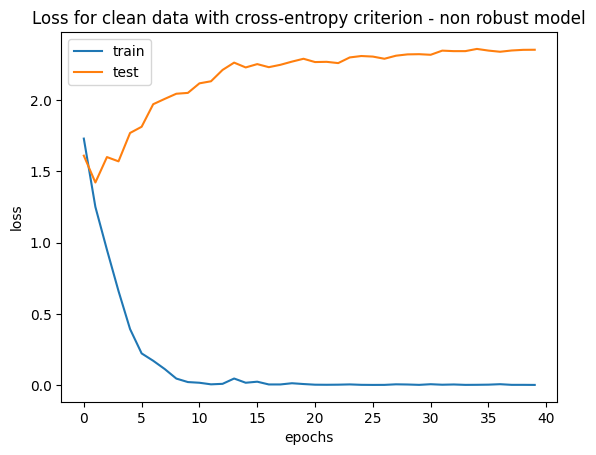

In [50]:
#model2, loss_train2, loss_val2, acc_train2, acc_val2
plot_loss(loss_train2, loss_val2, title = "Loss for clean data with cross-entropy criterion - non robust model")

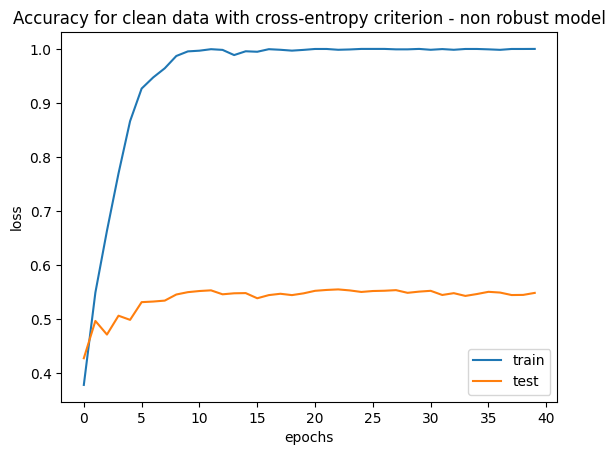

In [51]:
plot_loss(acc_train2, acc_val2, title="Accuracy for clean data with cross-entropy criterion - non robust model")

### UMAP

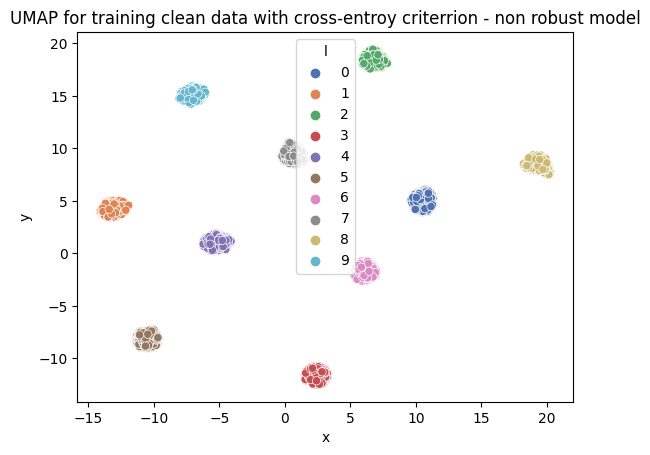

In [52]:
embeddings,labels = get_embedding(model2, train_loader)
model_umap2 = plot_umap(None, embeddings, labels, True, title = "UMAP for training clean data with cross-entroy criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

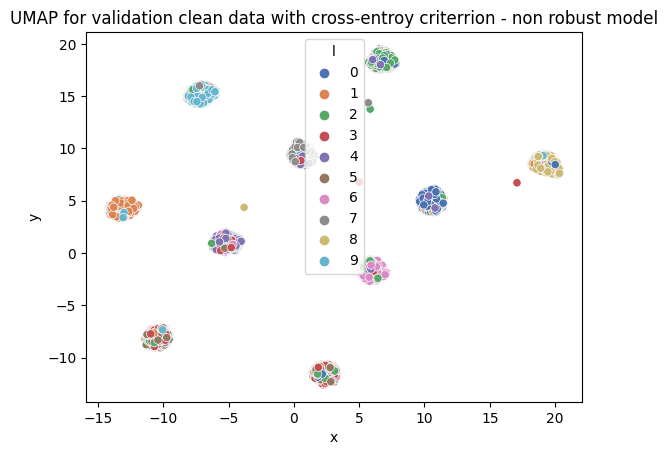

In [53]:
embeddings,labels = get_embedding(model2, val_loader)
plot_umap(model_umap2, embeddings, labels, title = "UMAP for validation clean data with cross-entroy criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

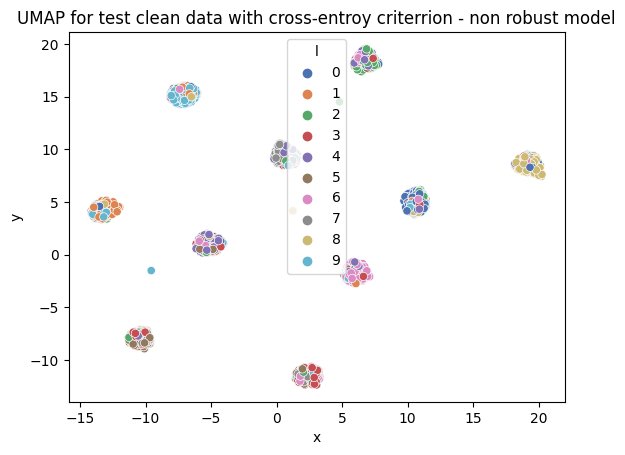

In [54]:
embeddings,labels = get_embedding(model2, test_loader)
plot_umap(model_umap2, embeddings, labels, title = "UMAP for test clean data with cross-entroy criterrion - non robust model")

In [55]:
model2, acc_test, acc_val = inference(model2, test_loader, val_loader)
print("test acuuracy is: ", acc_test[0],"\nvalidation accuracy is:", acc_val[0])

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                               

Adjusting learning rate of group 0 to 6.6514e-06.
test acuuracy is:  0.552832031622529 
validation accuracy is: 0.5489831349206349


# Part3

In [56]:
def noise(x):

    x = x + (0.1**0.5)*np.random.rand(3, 32, 32)
    return x

In [57]:
def distort(x):
    num_pixels=15
    value=1.0
    for channel in range(3):
        for _ in range(num_pixels):
            x[channel][int(random.random()*32)][int(random.random()*32)] = value
    return x

In [58]:
t2 = transforms.Compose([
                            transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0),
                            transforms.ToTensor(),
                            transforms.GaussianBlur(1),
                            transforms.Lambda(lambda x: noise(x)),
                            transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))])

In [59]:
dataset_val2 = MyDataset(X_val, y_val, t2)
dataset_train2 = MyDataset(X_train, y_train, t2)
dataset_test2 = MyDataset(X_test, y_test,t2)

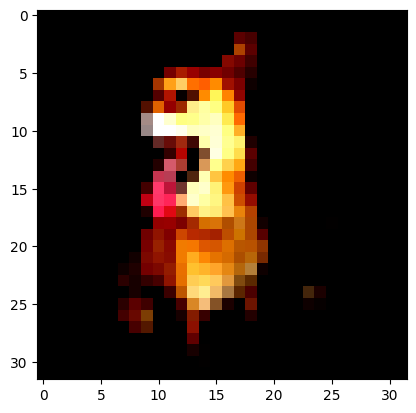

In [60]:
plt.imshow(dataset_val[10][0].permute(1,2,0))

In [61]:
train_loader2 = DataLoader(dataset_train2,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4)
val_loader2 = DataLoader(dataset_val2,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)
test_loader2 = DataLoader(dataset_test2,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

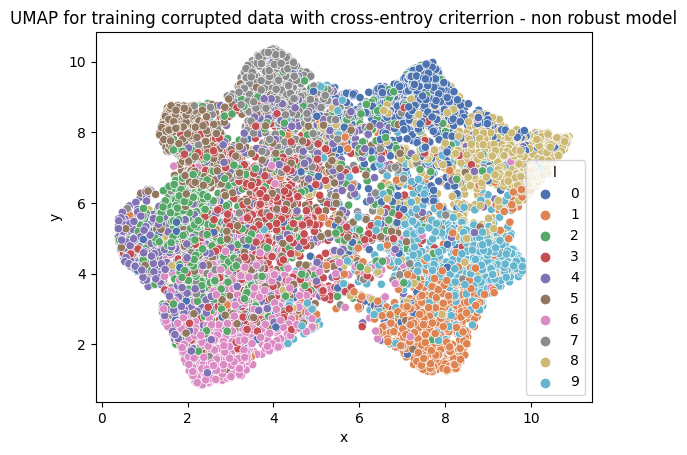

In [62]:
embeddings,labels = get_embedding(model2, train_loader2)
model_umap3 = plot_umap(None, embeddings, labels, True, title = "UMAP for training corrupted data with cross-entroy criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

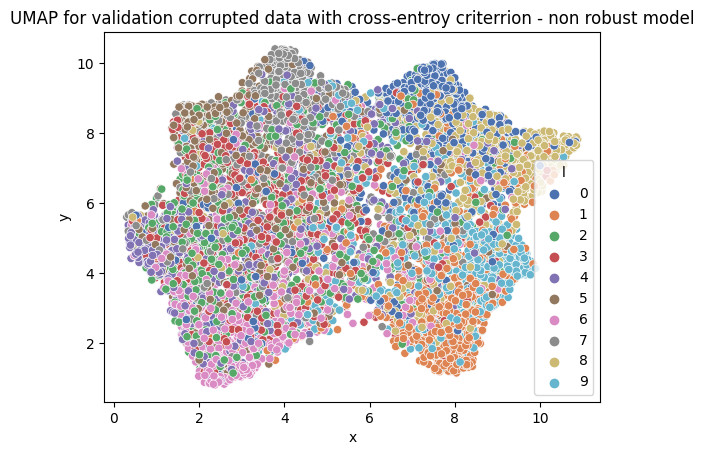

In [63]:
embeddings,labels = get_embedding(model2, val_loader2)
plot_umap(model_umap3, embeddings, labels, title = "UMAP for validation corrupted data with cross-entroy criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

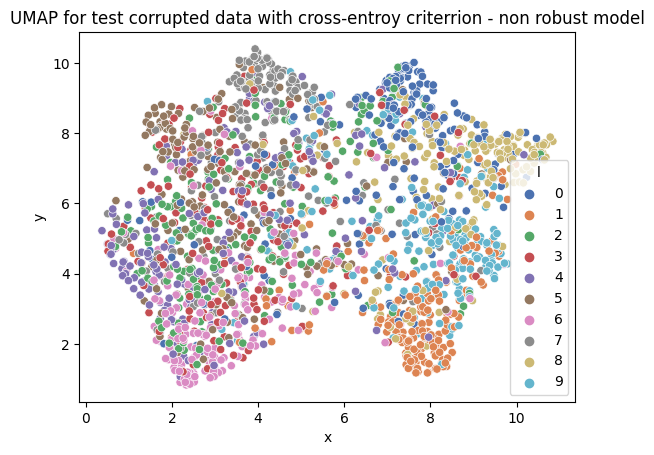

In [64]:
embeddings,labels = get_embedding(model2, test_loader2)
plot_umap(model_umap3, embeddings, labels, title = "UMAP for test corrupted data with cross-entroy criterrion - non robust model")

In [65]:
model2, acc_test2, acc_val2 = inference(model2, test_loader2, val_loader2)
print("test acuuracy is: ", acc_test2[0],"\nvalidation accuracy is:", acc_val2[0])

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                               

Adjusting learning rate of group 0 to 5.9863e-06.
test acuuracy is:  0.43476562574505806 
validation accuracy is: 0.42137896825396826


## Part4

In [66]:
model4 = ResNet18(3,10)
model4.to(device);

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model4.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
epochs = 40
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

Adjusting learning rate of group 0 to 5.0000e-04.


In [68]:
"""
train_set = CustomDataset(...)
train_loader = DataLoader(dataset=train_set, ...)
dev_set = CustomDataset(...)
dev_loader = DataLoader(dataset=dev_set, ...)

train_dev_sets = torch.utils.data.ConcatDataset([train_set, dev_set])
train_dev_loader = DataLoader(dataset=train_dev_sets, ...)
"""

'\ntrain_set = CustomDataset(...)\ntrain_loader = DataLoader(dataset=train_set, ...)\ndev_set = CustomDataset(...)\ndev_loader = DataLoader(dataset=dev_set, ...)\n\ntrain_dev_sets = torch.utils.data.ConcatDataset([train_set, dev_set])\ntrain_dev_loader = DataLoader(dataset=train_dev_sets, ...)\n'

In [69]:
model4, loss_train4, loss_val4, acc_train4, acc_val4 = train(model4, train_loader2, val_loader2)

 epoch1: train_loss-> 1.862318974507006, val_loss-> 1.7403882193186926, train accuracy -> 0.32644382911392406, val_accuracy -> 0.37797619047619047
Adjusting learning rate of group 0 to 4.5000e-04.


 epoch2: train_loss-> 1.5230048593086531, val_loss-> 1.538925844525534, train accuracy -> 0.4440268987341772, val_accuracy -> 0.4517609126984127
Adjusting learning rate of group 0 to 4.0500e-04.


 epoch3: train_loss-> 1.355553924282895, val_loss-> 1.4453701234999157, train accuracy -> 0.5060324367088608, val_accuracy -> 0.4836309523809524
Adjusting learning rate of group 0 to 3.6450e-04.


 epoch4: train_loss-> 1.2104611276071282, val_loss-> 1.407022928434705, train accuracy -> 0.5656645569620253, val_accuracy -> 0.5021081349206349
Adjusting learning rate of group 0 to 3.2805e-04.


 epoch5: train_loss-> 1.0762366554405116, val_loss-> 1.3588427097078353, train accuracy -> 0.6143196202531646, val_accuracy -> 0.5188492063492064
Adjusting learning rate of group 0 to 2.9525e-04.


 epoch6: train_loss-> 0.9415299937694888, val_loss-> 1.4085667000876532, train accuracy -> 0.6570411392405063, val_accuracy -> 0.5021081349206349
Adjusting learning rate of group 0 to 2.6572e-04.


 epoch7: train_loss-> 0.818589920484567, val_loss-> 1.4376728913140675, train accuracy -> 0.7013449367088608, val_accuracy -> 0.5189732142857143
Adjusting learning rate of group 0 to 2.3915e-04.


 epoch8: train_loss-> 0.6948676222487341, val_loss-> 1.4477191028140841, train accuracy -> 0.753065664556962, val_accuracy -> 0.5291418650793651
Adjusting learning rate of group 0 to 2.1523e-04.


 epoch9: train_loss-> 0.5738139873064017, val_loss-> 1.579942852731735, train accuracy -> 0.7955893987341772, val_accuracy -> 0.5307539682539683
Adjusting learning rate of group 0 to 1.9371e-04.


 epoch10: train_loss-> 0.47181575811361964, val_loss-> 1.609535022387429, train accuracy -> 0.8314873417721519, val_accuracy -> 0.5362103174603174
Adjusting learning rate of group 0 to 1.7434e-04.


 epoch11: train_loss-> 0.38461161433141444, val_loss-> 1.6091666846048265, train accuracy -> 0.8649129746835443, val_accuracy -> 0.5422867063492064
Adjusting learning rate of group 0 to 1.5691e-04.


 epoch12: train_loss-> 0.27852888197838505, val_loss-> 1.7248339766547793, train accuracy -> 0.9058544303797469, val_accuracy -> 0.5386904761904762
Adjusting learning rate of group 0 to 1.4121e-04.


 epoch13: train_loss-> 0.23055978628653515, val_loss-> 1.8044284184773762, train accuracy -> 0.9237539556962026, val_accuracy -> 0.5358382936507936
Adjusting learning rate of group 0 to 1.2709e-04.


 epoch14: train_loss-> 0.22569635746222508, val_loss-> 1.7691596803211032, train accuracy -> 0.9239517405063291, val_accuracy -> 0.5404265873015873
Adjusting learning rate of group 0 to 1.1438e-04.


 epoch15: train_loss-> 0.14433030312574363, val_loss-> 1.841433082308088, train accuracy -> 0.9546083860759493, val_accuracy -> 0.5483630952380952
Adjusting learning rate of group 0 to 1.0295e-04.


 epoch16: train_loss-> 0.13272007451027254, val_loss-> 1.8619715959306746, train accuracy -> 0.9570806962025317, val_accuracy -> 0.5432787698412699
Adjusting learning rate of group 0 to 9.2651e-05.


 epoch17: train_loss-> 0.11894562958350664, val_loss-> 1.8935656982754905, train accuracy -> 0.9625197784810127, val_accuracy -> 0.5565476190476191
Adjusting learning rate of group 0 to 8.3386e-05.


 epoch18: train_loss-> 0.10641929271477688, val_loss-> 1.9243900681298876, train accuracy -> 0.9678599683544303, val_accuracy -> 0.5447668650793651
Adjusting learning rate of group 0 to 7.5047e-05.


 epoch19: train_loss-> 0.07871952775535704, val_loss-> 1.9068735591948978, train accuracy -> 0.9773536392405063, val_accuracy -> 0.5538194444444444
Adjusting learning rate of group 0 to 6.7543e-05.


 epoch20: train_loss-> 0.07033822678406781, val_loss-> 1.9664946813431998, train accuracy -> 0.9785403481012658, val_accuracy -> 0.5536954365079365
Adjusting learning rate of group 0 to 6.0788e-05.


 epoch21: train_loss-> 0.06729820771496507, val_loss-> 1.9507050741286505, train accuracy -> 0.9798259493670886, val_accuracy -> 0.5531994047619048
Adjusting learning rate of group 0 to 5.4709e-05.


 epoch22: train_loss-> 0.052318584480428997, val_loss-> 2.0112999223527455, train accuracy -> 0.9840783227848101, val_accuracy -> 0.5510912698412699
Adjusting learning rate of group 0 to 4.9239e-05.


 epoch23: train_loss-> 0.05149742687427545, val_loss-> 2.0096927389265997, train accuracy -> 0.9856606012658228, val_accuracy -> 0.5494791666666666
Adjusting learning rate of group 0 to 4.4315e-05.


 epoch24: train_loss-> 0.04799310139179984, val_loss-> 2.003006859431191, train accuracy -> 0.9849683544303798, val_accuracy -> 0.5554315476190477
Adjusting learning rate of group 0 to 3.9883e-05.


 epoch25: train_loss-> 0.048796843053608, val_loss-> 2.0122968053060863, train accuracy -> 0.986056170886076, val_accuracy -> 0.5550595238095238
Adjusting learning rate of group 0 to 3.5895e-05.


 epoch26: train_loss-> 0.042969762123649634, val_loss-> 2.0568176772859363, train accuracy -> 0.9863528481012658, val_accuracy -> 0.5555555555555556
Adjusting learning rate of group 0 to 3.2305e-05.


 epoch27: train_loss-> 0.042907975166092946, val_loss-> 2.0561468052485634, train accuracy -> 0.9877373417721519, val_accuracy -> 0.5451388888888888
Adjusting learning rate of group 0 to 2.9075e-05.


 epoch28: train_loss-> 0.03676905668093056, val_loss-> 2.0553972323735556, train accuracy -> 0.9900118670886076, val_accuracy -> 0.5499751984126984
Adjusting learning rate of group 0 to 2.6167e-05.


 epoch29: train_loss-> 0.03229525883363772, val_loss-> 2.0472175091032, train accuracy -> 0.9908030063291139, val_accuracy -> 0.5549355158730159
Adjusting learning rate of group 0 to 2.3551e-05.


 epoch30: train_loss-> 0.032234810198409646, val_loss-> 2.0464958785072205, train accuracy -> 0.9910996835443038, val_accuracy -> 0.5546875
Adjusting learning rate of group 0 to 2.1196e-05.


 epoch31: train_loss-> 0.027060321868173306, val_loss-> 2.095421902717106, train accuracy -> 0.9936708860759493, val_accuracy -> 0.5498511904761905
Adjusting learning rate of group 0 to 1.9076e-05.


 epoch32: train_loss-> 0.027432233631563715, val_loss-> 2.058198118966723, train accuracy -> 0.9927808544303798, val_accuracy -> 0.5555555555555556
Adjusting learning rate of group 0 to 1.7168e-05.


 epoch33: train_loss-> 0.02752829870633498, val_loss-> 2.0486192135583785, train accuracy -> 0.9919897151898734, val_accuracy -> 0.5565476190476191
Adjusting learning rate of group 0 to 1.5452e-05.


 epoch34: train_loss-> 0.026669924159215975, val_loss-> 2.0611970292197332, train accuracy -> 0.9918908227848101, val_accuracy -> 0.5574156746031746
Adjusting learning rate of group 0 to 1.3906e-05.


 epoch35: train_loss-> 0.03018231231342011, val_loss-> 2.129117097173418, train accuracy -> 0.9921875, val_accuracy -> 0.5462549603174603
Adjusting learning rate of group 0 to 1.2516e-05.


 epoch36: train_loss-> 0.02565445707922306, val_loss-> 2.0852212678818476, train accuracy -> 0.9930775316455697, val_accuracy -> 0.5505952380952381
Adjusting learning rate of group 0 to 1.1264e-05.


 epoch37: train_loss-> 0.034484259324454807, val_loss-> 2.0725784150380937, train accuracy -> 0.9929786392405063, val_accuracy -> 0.5550595238095238
Adjusting learning rate of group 0 to 1.0138e-05.


 epoch38: train_loss-> 0.025295226280636424, val_loss-> 2.1089507417073325, train accuracy -> 0.9937697784810127, val_accuracy -> 0.550843253968254
Adjusting learning rate of group 0 to 9.1240e-06.


 epoch39: train_loss-> 0.024607323982481714, val_loss-> 2.0553277901240756, train accuracy -> 0.9939675632911392, val_accuracy -> 0.5608878968253969
Adjusting learning rate of group 0 to 8.2116e-06.


 epoch40: train_loss-> 0.024917299122419915, val_loss-> 2.089505040456378, train accuracy -> 0.9923852848101266, val_accuracy -> 0.5567956349206349
Adjusting learning rate of group 0 to 7.3904e-06.


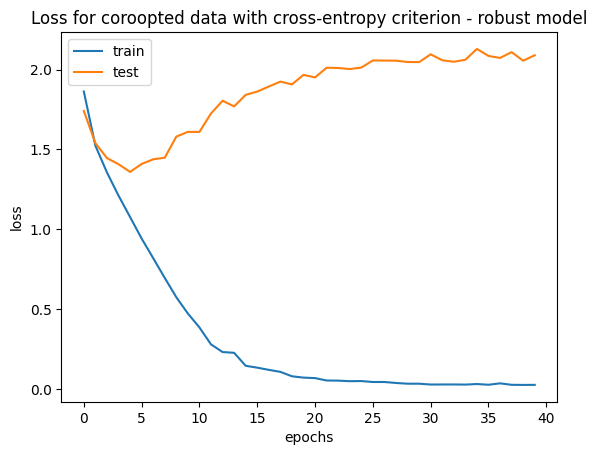

In [70]:
#model2, loss_train2, loss_val2, acc_train2, acc_val2
plot_loss(loss_train4, loss_val4, title = "Loss for coroopted data with cross-entropy criterion - robust model")

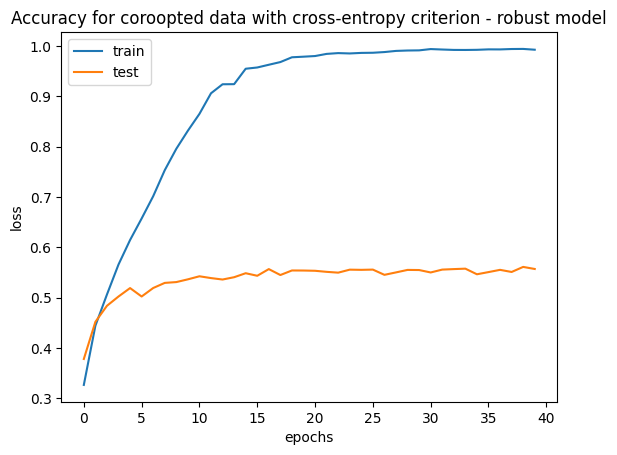

In [71]:
plot_loss(acc_train4, acc_val4, title="Accuracy for coroopted data with cross-entropy criterion - robust model")

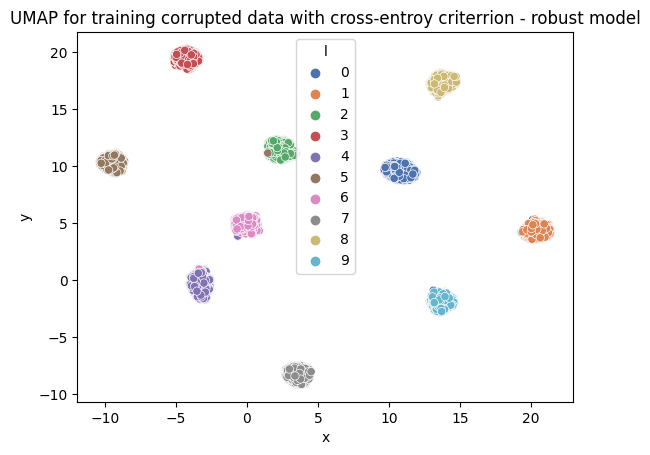

In [72]:
embeddings4,labels4 = get_embedding(model4, train_loader2)
model_umap4 = plot_umap(None, embeddings4, labels4,True, title = "UMAP for training corrupted data with cross-entroy criterrion - robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

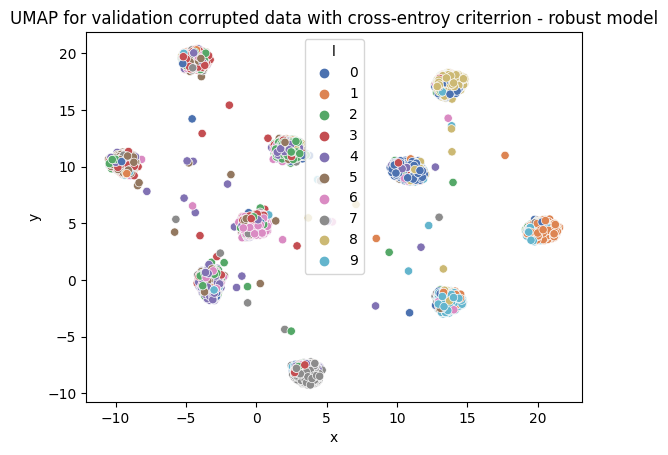

In [73]:
embeddings4,labels4 = get_embedding(model4, val_loader2)
plot_umap(model_umap4, embeddings4, labels4, title = "UMAP for validation corrupted data with cross-entroy criterrion - robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

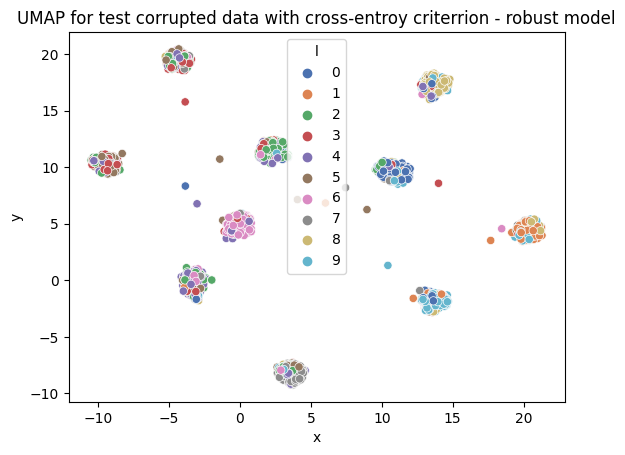

In [74]:
embeddings4,labels4 = get_embedding(model4, test_loader2)
plot_umap(model_umap4, embeddings4, labels4, title = "UMAP for test corrupted data with cross-entroy criterrion - robust model")

In [75]:
model4, acc_test4, acc_val4 = inference(model4, test_loader2, val_loader2)
print("test acuuracy is: ", acc_test4[0],"\nvalidation accuracy is:", acc_val4[0])

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                               

Adjusting learning rate of group 0 to 6.6514e-06.
test acuuracy is:  0.5648437514901161 
validation accuracy is: 0.5540674603174603


## Part6

### non-robust Model with Angular loss

In [76]:
model5 = ResNet18(3,10, metric = True)
model5.to(device);

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [77]:
criterion = losses.AngularLoss(alpha=40)
optimizer = torch.optim.AdamW(model5.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
epochs = 40
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

Adjusting learning rate of group 0 to 5.0000e-04.


In [78]:
model5, loss_train5, loss_val5, acc_train5, acc_val5 = train(model5, train_loader, val_loader, False)

 epoch1: train_loss-> 4.670422907117047, val_loss-> 4.866132774050274, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.5000e-04.


 epoch2: train_loss-> 4.479618703262715, val_loss-> 4.605919811460707, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.0500e-04.


 epoch3: train_loss-> 4.27471159832387, val_loss-> 4.5424698193868, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.6450e-04.


 epoch4: train_loss-> 4.069433588015882, val_loss-> 4.508131901423137, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.2805e-04.


 epoch5: train_loss-> 3.8116082979153982, val_loss-> 4.543074921956138, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.9525e-04.


 epoch6: train_loss-> 3.560478964938393, val_loss-> 4.6098573926895385, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.6572e-04.


 epoch7: train_loss-> 3.2511788742451726, val_loss-> 4.5041466062031095, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.3915e-04.


 epoch8: train_loss-> 2.89120138445987, val_loss-> 4.523837819931999, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.1523e-04.


 epoch9: train_loss-> 2.577485475359084, val_loss-> 4.564004621808491, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.9371e-04.


 epoch10: train_loss-> 2.249053766455831, val_loss-> 4.61081323926411, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.7434e-04.


 epoch11: train_loss-> 1.9699474422237542, val_loss-> 4.616468558235774, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.5691e-04.


 epoch12: train_loss-> 1.7847047791450839, val_loss-> 4.6243635094355025, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.4121e-04.


 epoch13: train_loss-> 1.534933080024357, val_loss-> 4.678425013072907, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.2709e-04.


 epoch14: train_loss-> 1.455438181757927, val_loss-> 4.628648405983334, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.1438e-04.


 epoch15: train_loss-> 1.3675765085823928, val_loss-> 4.644317123625013, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.0295e-04.


 epoch16: train_loss-> 1.2791598980562597, val_loss-> 4.654408008333236, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 9.2651e-05.


 epoch17: train_loss-> 1.2394097432305542, val_loss-> 4.656171038037255, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 8.3386e-05.


 epoch18: train_loss-> 1.205173805544648, val_loss-> 4.653814217400929, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 7.5047e-05.


 epoch19: train_loss-> 1.178441278919389, val_loss-> 4.6570683471740235, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 6.7543e-05.


 epoch20: train_loss-> 1.1756065842471546, val_loss-> 4.661895676264687, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 6.0788e-05.


 epoch21: train_loss-> 1.1691225808632524, val_loss-> 4.671612334629846, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 5.4709e-05.


 epoch22: train_loss-> 1.1402457499805885, val_loss-> 4.682355846677508, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.9239e-05.


 epoch23: train_loss-> 1.1461767607097384, val_loss-> 4.673966093668862, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.4315e-05.


 epoch24: train_loss-> 1.138170223447341, val_loss-> 4.678432941436768, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.9883e-05.


 epoch25: train_loss-> 1.1259873675394663, val_loss-> 4.685208922340756, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.5895e-05.


 epoch26: train_loss-> 1.1248481767841532, val_loss-> 4.695463267583696, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.2305e-05.


 epoch27: train_loss-> 1.1184943518306636, val_loss-> 4.681401222471207, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.9075e-05.


 epoch28: train_loss-> 1.116004484363749, val_loss-> 4.698727168734112, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.6167e-05.


 epoch29: train_loss-> 1.1168590901018698, val_loss-> 4.682504173309084, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.3551e-05.


 epoch30: train_loss-> 1.1157328788238237, val_loss-> 4.684468606161693, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.1196e-05.


 epoch31: train_loss-> 1.120782679017586, val_loss-> 4.697132682043408, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.9076e-05.


 epoch32: train_loss-> 1.114797529917729, val_loss-> 4.710284040087745, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.7168e-05.


 epoch33: train_loss-> 1.1186848705327963, val_loss-> 4.704620599746704, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.5452e-05.


 epoch34: train_loss-> 1.1130713963810401, val_loss-> 4.695242783379933, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.3906e-05.


 epoch35: train_loss-> 1.1142745998841297, val_loss-> 4.690754334131877, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.2516e-05.


 epoch36: train_loss-> 1.1055762051027032, val_loss-> 4.701460357696291, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.1264e-05.


 epoch37: train_loss-> 1.104750855436808, val_loss-> 4.698283002490089, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.0138e-05.


 epoch38: train_loss-> 1.1050249749346623, val_loss-> 4.699858975788904, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 9.1240e-06.


 epoch39: train_loss-> 1.104730202804638, val_loss-> 4.694266886938186, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 8.2116e-06.


 epoch40: train_loss-> 1.1124601424494875, val_loss-> 4.710878534922524, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 7.3904e-06.


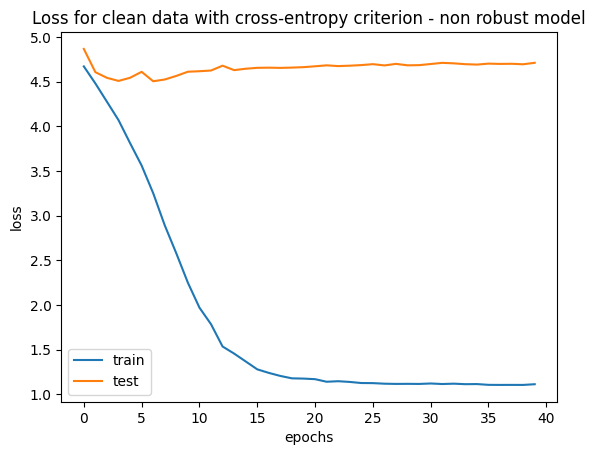

In [79]:
#model2, loss_train2, loss_val2, acc_train2, acc_val2
plot_loss(loss_train5, loss_val5, title = "Loss for clean data with cross-entropy criterion - non robust model")

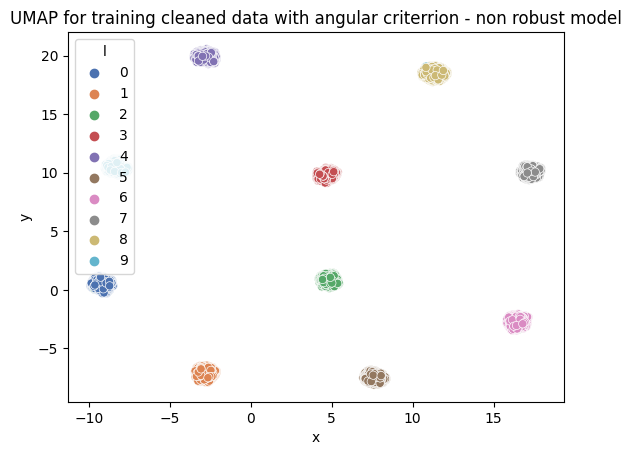

In [80]:
embeddings5,labels5 = get_embedding(model5, train_loader)
model_umap5_1 = plot_umap(None, embeddings5, labels5,True, title = "UMAP for training cleaned data with angular criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

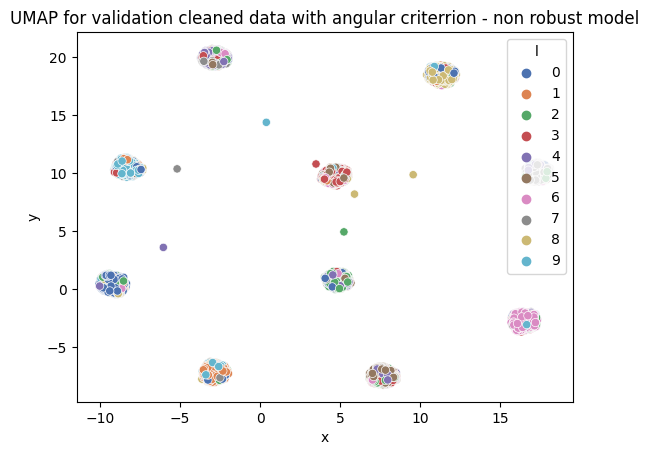

In [81]:
embeddings5,labels5 = get_embedding(model5, val_loader)
plot_umap(model_umap5_1, embeddings5, labels5, title = "UMAP for validation cleaned data with angular criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

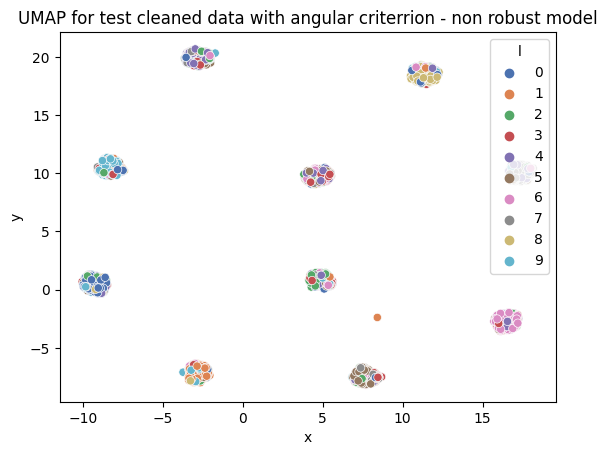

In [82]:
embeddings5,labels5 = get_embedding(model5, test_loader)
plot_umap(model_umap5_1, embeddings5, labels5, title = "UMAP for test cleaned data with angular criterrion - non robust model")

#### coroptted dataset

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


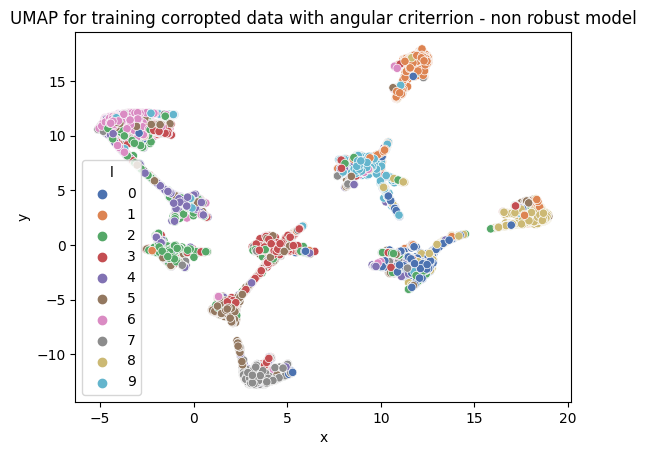

In [83]:
embeddings5,labels5 = get_embedding(model5, train_loader2)
model_umap5_2 = plot_umap(None, embeddings5, labels5,True, title = "UMAP for training corropted data with angular criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

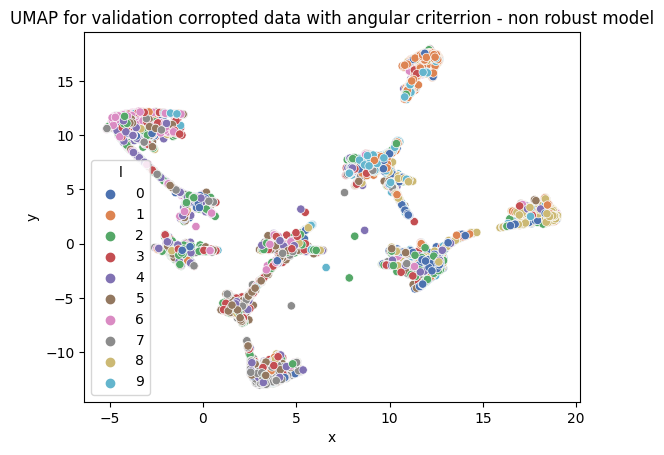

In [84]:
embeddings5,labels5 = get_embedding(model5, val_loader2)
plot_umap(model_umap5_2, embeddings5, labels5, title = "UMAP for validation corropted data with angular criterrion - non robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

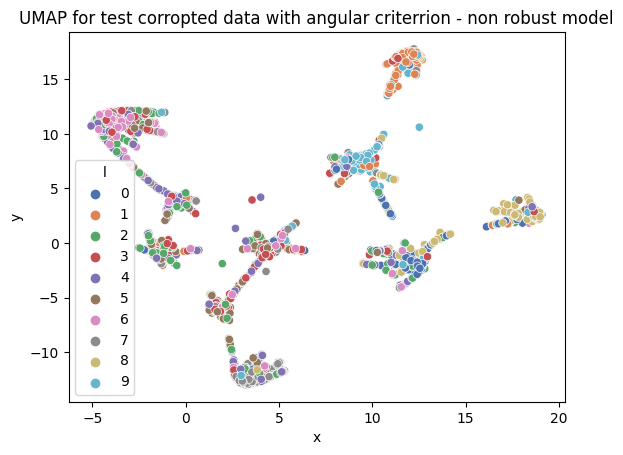

In [85]:
embeddings5,labels5 = get_embedding(model5, test_loader2)
plot_umap(model_umap5_2, embeddings5, labels5, title = "UMAP for test corropted data with angular criterrion - non robust model")

In [86]:
embedding_train_clean, y_train_clean = get_embedding(model5, train_loader)
embedding_val_clean, y_val_clean = get_embedding(model5, val_loader)
embedding_test_clean, y_test_clean = get_embedding(model5, test_loader)

embedding_train_corropted, y_train_corropted = get_embedding(model5, train_loader2)
embedding_val_corropted, y_val_corropted = get_embedding(model5, val_loader2)
embedding_test_corropted, y_test_corropted = get_embedding(model5, test_loader2)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [87]:
embedding_val_clean.shape

(8000, 128)

In [88]:
knn5 = KNN_classifier(None, embedding_train_clean, y_train_clean, \
                                            embedding_val_clean, y_val_clean, 10, "accuracy on clean validation" )

knn5 = KNN_classifier(knn5, embedding_train_clean, y_train_clean, \
                                            embedding_test_clean, y_test_clean, 10, "accuracy on clean test" )

knn5 = KNN_classifier(knn5, embedding_train_clean, y_train_clean, \
                                            embedding_val_corropted, y_val_corropted, 10, "accuracy on corropted test" )

knn5 = KNN_classifier(knn5, embedding_train_clean, y_train_clean, \
                                            embedding_test_corropted, y_test_corropted, 10, "accuracy on corropted test" )

Accuracy of on accuracy on clean validation: 59%
Accuracy of on accuracy on clean test: 58%
Accuracy of on accuracy on corropted test: 45%
Accuracy of on accuracy on corropted test: 47%


### Robust model with Angular loss

In [89]:
model6 = ResNet18(3,10, metric = True)
model6.to(device);

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [90]:
criterion = losses.AngularLoss(alpha=40)
optimizer = torch.optim.AdamW(model6.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
epochs = 40
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

Adjusting learning rate of group 0 to 5.0000e-04.


In [91]:
model6, loss_train6, loss_val6, acc_train6, acc_val6 = train(model6, train_loader2, val_loader2, False)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                               

 epoch1: train_loss-> 4.711930353430253, val_loss-> 4.8074557970440575, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.5000e-04.


 epoch2: train_loss-> 4.5645673546609995, val_loss-> 4.735389262910873, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.0500e-04.


 epoch3: train_loss-> 4.4902819410155095, val_loss-> 4.601001936291891, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.6450e-04.


 epoch4: train_loss-> 4.386422606963146, val_loss-> 4.56544600214277, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.2805e-04.


 epoch5: train_loss-> 4.2630716909336135, val_loss-> 4.537231789694892, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.9525e-04.


 epoch6: train_loss-> 4.151233256617679, val_loss-> 4.474908310269552, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.6572e-04.


 epoch7: train_loss-> 4.006704267067246, val_loss-> 4.440065111432757, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.3915e-04.


 epoch8: train_loss-> 3.902641181704364, val_loss-> 4.4812210325210815, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.1523e-04.


 epoch9: train_loss-> 3.740005313595639, val_loss-> 4.531637808633229, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.9371e-04.


 epoch10: train_loss-> 3.6049329223512094, val_loss-> 4.417967542769417, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.7434e-04.


 epoch11: train_loss-> 3.454661456844475, val_loss-> 4.406007823489961, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.5691e-04.


 epoch12: train_loss-> 3.2605739801744873, val_loss-> 4.498770460249886, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.4121e-04.


 epoch13: train_loss-> 3.105695160129402, val_loss-> 4.494443174392458, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.2709e-04.


 epoch14: train_loss-> 2.9431359103963346, val_loss-> 4.47800840650286, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.1438e-04.


 epoch15: train_loss-> 2.756902281242081, val_loss-> 4.495535415316385, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.0295e-04.


 epoch16: train_loss-> 2.626404388041436, val_loss-> 4.4953503797924705, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 9.2651e-05.


 epoch17: train_loss-> 2.4538593073434467, val_loss-> 4.489360411961873, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 8.3386e-05.


 epoch18: train_loss-> 2.3124692636200144, val_loss-> 4.552644143028865, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 7.5047e-05.


 epoch19: train_loss-> 2.1695865256876887, val_loss-> 4.538529422548082, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 6.7543e-05.


 epoch20: train_loss-> 2.03424583790423, val_loss-> 4.539680704237923, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 6.0788e-05.


 epoch21: train_loss-> 1.947855934312072, val_loss-> 4.559293474469866, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 5.4709e-05.


 epoch22: train_loss-> 1.8740617142447942, val_loss-> 4.5680723001086525, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.9239e-05.


 epoch23: train_loss-> 1.738884847375411, val_loss-> 4.540805759884062, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 4.4315e-05.


 epoch24: train_loss-> 1.6936058519007284, val_loss-> 4.579131270211841, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.9883e-05.


 epoch25: train_loss-> 1.6594020580943627, val_loss-> 4.566388924916585, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.5895e-05.


 epoch26: train_loss-> 1.5996761137171636, val_loss-> 4.596099270714654, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 3.2305e-05.


 epoch27: train_loss-> 1.5520256244683568, val_loss-> 4.618650353144085, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.9075e-05.


 epoch28: train_loss-> 1.5288985967636108, val_loss-> 4.594264215893215, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.6167e-05.


 epoch29: train_loss-> 1.5266493966307821, val_loss-> 4.596603105938624, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.3551e-05.


 epoch30: train_loss-> 1.4820735243302356, val_loss-> 4.591390503777398, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 2.1196e-05.


 epoch31: train_loss-> 1.446852263770526, val_loss-> 4.586917990729923, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.9076e-05.


 epoch32: train_loss-> 1.4294812898092633, val_loss-> 4.602333220224532, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.7168e-05.


 epoch33: train_loss-> 1.4053653546526461, val_loss-> 4.626065019577268, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.5452e-05.


 epoch34: train_loss-> 1.4112746708000763, val_loss-> 4.608150421626984, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.3906e-05.


 epoch35: train_loss-> 1.3945665744286548, val_loss-> 4.605935092956301, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.2516e-05.


 epoch36: train_loss-> 1.3976024125195756, val_loss-> 4.5814032554626465, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.1264e-05.


 epoch37: train_loss-> 1.365752085477491, val_loss-> 4.619250884131779, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 1.0138e-05.


 epoch38: train_loss-> 1.3743152871162077, val_loss-> 4.580534564124213, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 9.1240e-06.


 epoch39: train_loss-> 1.3565030301673502, val_loss-> 4.6123325030008955, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 8.2116e-06.


 epoch40: train_loss-> 1.3429757079368905, val_loss-> 4.618431174565876, train accuracy -> 0.0, val_accuracy -> 0.0
Adjusting learning rate of group 0 to 7.3904e-06.


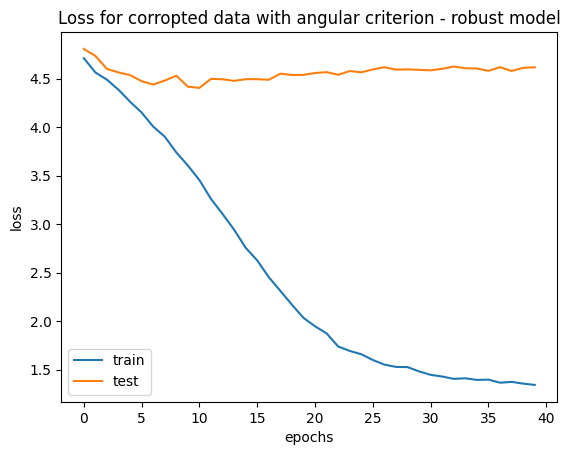

In [92]:
#model2, loss_train2, loss_val2, acc_train2, acc_val2
plot_loss(loss_train6, loss_val6, title = "Loss for corropted data with angular criterion - robust model")

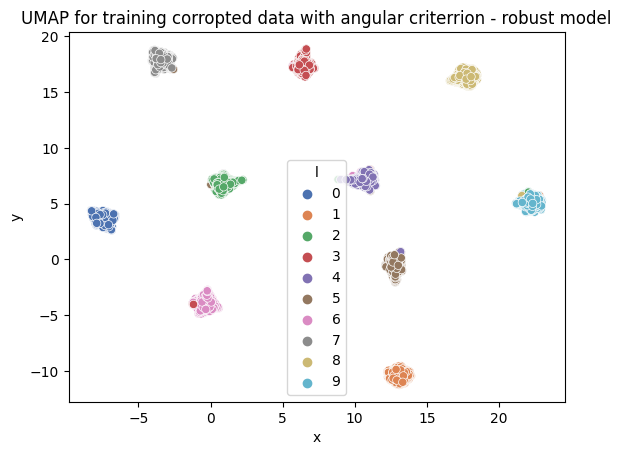

In [93]:
embeddings6,labels6 = get_embedding(model6, train_loader2)
model_umap6_1 = plot_umap(None, embeddings6, labels6,True, title = "UMAP for training corropted data with angular criterrion - robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

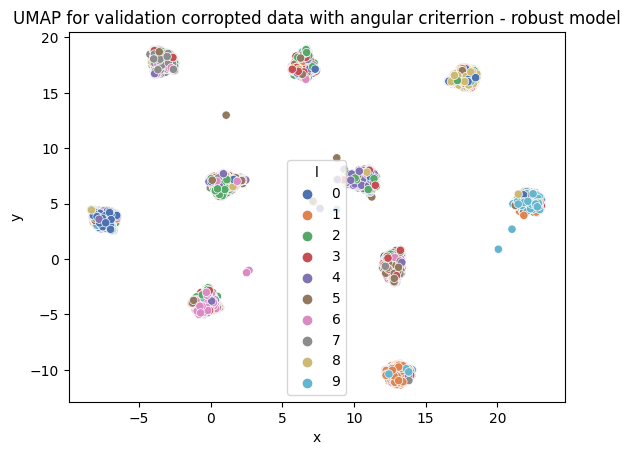

In [94]:
embeddings6,labels6 = get_embedding(model6, val_loader2)
plot_umap(model_umap6_1 , embeddings6, labels6, title = "UMAP for validation corropted data with angular criterrion - robust model")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

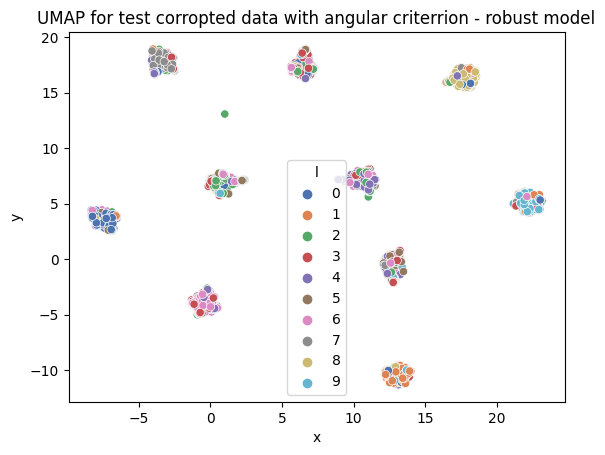

In [95]:
embeddings6,labels6 = get_embedding(model6, test_loader2)
plot_umap(model_umap6_1 , embeddings6, labels6, title = "UMAP for test corropted data with angular criterrion - robust model")

In [96]:
embedding_train_corropted6, y_train_corropted6 = get_embedding(model6, train_loader2)
embedding_val_corropted6, y_val_corropted6 = get_embedding(model6, val_loader2)
embedding_test_corropted6, y_test_corropted6 = get_embedding(model6, test_loader2)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [97]:
knn6 = KNN_classifier(None, embedding_train_corropted6, y_train_corropted6, \
                                            embedding_val_corropted6, y_val_corropted6, 10, "accuracy on corropted test" )

knn6 = KNN_classifier(knn6, embedding_train_corropted6, y_train_corropted6, \
                                            embedding_test_corropted6, y_test_corropted6, 10, "accuracy on corropted test" )

Accuracy of on accuracy on corropted test: 57%
Accuracy of on accuracy on corropted test: 58%
